In [2]:
'''
测试
pandas的json读取
'''
import pandas as pd
info_filename = r"E:\pycharm files\爬虫\房天下二手房定价模型\data\data3000.json"
df = pd.read_json(info_filename)

In [3]:
'''
查看物业类型属性
提取物业类型为住宅的数据
'''

print(set(df['物业类型']))
print(df['物业类型'].isna().sum())
print(df['物业类型'].value_counts())
idx = df['物业类型']=='住宅'
df1 = df.loc[idx,:]
df1.reset_index(inplace=True)
print(len(df1))

{'住宅', '别墅'}
0
住宅    2975
别墅      10
Name: 物业类型, dtype: int64
2975


In [4]:
# 查看多少属性后是别墅属性，删除别墅属性
import numpy as np

df1.info()
df1 = df1.iloc[:,0:38]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975 entries, 0 to 2974
Data columns (total 50 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       2975 non-null   int64  
 1   url         2975 non-null   object 
 2   标题          2975 non-null   object 
 3   地址          2975 non-null   object 
 4   优势1         2975 non-null   object 
 5   优势2         2975 non-null   object 
 6   优势3         2975 non-null   object 
 7   总价          2975 non-null   float64
 8   户型          2975 non-null   object 
 9   建筑面积        2975 non-null   object 
 10  单价          2975 non-null   object 
 11  朝向          2975 non-null   object 
 12  装修          2975 non-null   object 
 13  楼层层次        2975 non-null   object 
 14  总楼层         2975 non-null   float64
 15  ID          2975 non-null   int64  
 16  小区          2975 non-null   object 
 17  区域          2975 non-null   object 
 18  有无电梯        2975 non-null   object 
 19  产权性质        2960 non-null  

In [5]:
'''
处理户型属性：
将四室两厅两卫 拆分为 卧室4 客厅2 卫生间2
'''
import re
record_size = len(df1)
zeros_array = np.zeros((record_size,3))
# 户型df
df_houseType = pd.DataFrame(zeros_array,columns=['卧室','客厅','卫生间'])

# map函数
def split_houseType(x):
    numbers = re.findall(r'\d+', x)
    if(numbers==[]):
        return [0,0,0]
    return numbers

series_houseType = df1["户型"].map(lambda x:split_houseType(x))
for i in range(record_size):
    df_houseType.iloc[i,0] = int(series_houseType[i][0])
    df_houseType.iloc[i,1] = int(series_houseType[i][1])
    df_houseType.iloc[i,2] = int(series_houseType[i][2])

df2 = pd.concat([df1,df_houseType],axis=1)

In [6]:
# value_counts()`：计算Series中每个值的出现次数。
print(df2['容  积  率'].isna().sum())
print(df2['绿  化  率'].isna().sum())
print(df2['物业费用'].isna().sum())
print(df2['产权年限'].isna().sum())
print(df2['人车分流'].isna().sum())
print(df2['建筑年代'].isna().sum())

17
17
89
1325
0
0


In [7]:
'''
容积率 总户数 平均值填充
'''
df2['容  积  率'].fillna(round(df2['容  积  率'].mean(),2),inplace=True)
df2['总  户  数'].fillna(round(df2['总  户  数'].mean(),2),inplace=True)

In [8]:
# 产权年限 提取数字
df2['产权年限'] = df2['产权年限'].fillna('70')
df2['产权年限'] = df2['产权年限'].map(lambda x:int(x[0:2]))

In [9]:
# 人车分流 转为0-1
dic_map = {'无':0,'有':1}
df2['人车分流'] = df2['人车分流'].map(dic_map)

In [10]:
'''
将 绿化率 属性上的nan值填充为30%，再转为数值属性
'''
def clean_green(x):
    numbers = re.findall(r'\d+', x)
    return int(numbers[0])
print(df2['绿  化  率'].value_counts()[0])
idx_nan = df2['绿  化  率'].isna()
df2['绿  化  率'] = df2['绿  化  率'].fillna("30%")
df2['绿  化  率'] = df2['绿  化  率'].map(lambda x:clean_green(x))

929


In [11]:
# 将 建筑年代 转为数值类型
def clean_buildYear(x):
    numbers = re.findall(r'\d+', x)
    return int(numbers[0])
df2['建筑年代'] = df2['建筑年代'].map(lambda x:clean_buildYear(x))

In [12]:
# 将 建筑类型 进行one-hot编码
# print(df2['建筑类型'].isna().sum())
padding_value = df2['建筑类型'].value_counts().index[0]
df2['建筑类型'].fillna(padding_value,inplace=True)
df2['建筑类型'].value_counts()

板楼         2373
板塔结合        242
板楼,塔楼       173
塔楼          166
板楼,板塔结合      19
塔楼,塔板结合       2
Name: 建筑类型, dtype: int64

In [13]:
# 将 物业费用 转为数值类型
def clean_fare(x):
    # print(x)
    if(pd.notna(x)):
        numbers = re.findall(r"\d+\.?\d*", x)
        if len(numbers)>1:
            return (float(numbers[0])+float(numbers[1]))/2
        return float(numbers[0])
    else:
        return 0

idx_nan = df2['物业费用'].isna()
num_notnan = sum(~idx_nan)
df2['物业费用'] = df2['物业费用'].map(lambda x:clean_fare(x))
df2.loc[idx_nan,"物业费用"] = (df2.loc[~idx_nan,"物业费用"].median())

In [14]:
'''
清洗 参考价格，将属性值为暂无的记录用平均参考价格填充
'''
def clean_aveprice(x):
    if x=='暂无':
        return np.nan
    numbers = re.findall(r'\d+', x)
    return int(numbers[0])
df2['参考均价'] = df2['参考均价'].map(lambda x:clean_aveprice(x))

df2['参考均价'].fillna(round(df2['参考均价'].mean()),inplace=True)

In [15]:
'''
将挂牌时间 处理为Timestamp
'''
df2['挂牌时间'] = df2['挂牌时间'].map(lambda x:pd.Timestamp(x).timestamp()/(60*60*24))

In [16]:
'''
将 楼层层次 装修 朝向 区域 转为 one-hot编码
'''
df3 = pd.get_dummies(df2, prefix_sep="_", columns=['区域','楼层层次','装修','朝向'])

In [17]:
'''
清洗 单价
'''

def clean_price(x):
    numbers = re.findall(r'\d+', x)
    return int(numbers[0])
df3['单价'] = df3['单价'].map(lambda x:clean_price(x))

In [18]:
'''
清洗 建筑面积
'''
def clean_square(x):
    numbers = re.findall(r'\d+', x)
    return int(numbers[0])
df3['建筑面积'] = df3['建筑面积'].map(lambda x:clean_square(x))

In [19]:
'''
清洗 有无电梯
'''
dic_map = {"有":1,"无":0}
df3['有无电梯'] = df3['有无电梯'].map(dic_map)

In [20]:
'''
将 产权性质 nan处填充 个人产权
并one-hot编码
'''
df3['产权性质'].fillna("个人产权",inplace=True)
df4 = pd.get_dummies(df3, prefix_sep="_", columns=['产权性质'])

In [21]:
def clean_buildType(x):
    if len(x)>2:
        return '板塔结合'
    else:
        return x
df4['建筑类型'] = df4['建筑类型'].map(lambda x:clean_buildType(x))
df5 = pd.get_dummies(df4, prefix_sep="_", columns=['建筑类型'])

In [22]:
'''
将优势1 转为one-hot编码
'''
df5['优势1'] = df5['优势1'].map(lambda x:str(x))
df6 = pd.get_dummies(df5, prefix_sep="_", columns=['优势1'])

In [23]:
'''
优质教育 one—hot
'''
idx = df6['优势2']=="优质教育"
zeros_array = np.zeros((len(df6),1))
df_edu = pd.DataFrame(zeros_array,columns=["优质教育"])
df_edu.loc[idx,:] = 1
df7 = pd.concat([df6,df_edu],axis=1)


In [24]:
'''
附件地铁 one-hot
'''
idx = (df7['优势2']=="优质教育")
df7.loc[idx,"优势2"] = "[]"
idx = ~(df7['优势2']=="[]")
df7.loc[idx,"优势3"] = df7.loc[idx,"优势2"] 
df7['优势3'] = df7['优势3'].map(lambda x:str(x))
idx = ~(df7['优势3']=="[]")
df7.loc[:,"附件地铁"] = np.zeros((len(df7),1))
df7.loc[idx,"附件地铁"] = 1

In [25]:
array_nan = np.full((len(df2),3),np.nan)
df_address = pd.DataFrame(array_nan,columns=["小区","地址",'url'])
for i in range(len(df2)):
    df_address.loc[i,"小区"] = "江苏省无锡市"+df2.loc[i,'区域'] + df2.loc[i,'小区']
    df_address.loc[i,"地址"] = "江苏省无锡市"+df2.loc[i,'区域'] + df2.loc[i,'地址']
    df_address.loc[i,"url"] = df2.loc[i,'url']
df_address.to_csv(r"E:\pycharm files\housing_pricing_model\data\经纬度信息.csv",index=False,encoding='utf-8')

In [26]:
"1"*10

'1111111111'

In [27]:
idx_keep = [9,10,11,14,18,24,25,26,27,28,29,30,31]
idx_keep.extend(list(range(32,71)))
print(idx_keep)

[9, 10, 11, 14, 18, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [28]:
'''

'''
df5.to_csv(r"E:\pycharm files\housing_pricing_model\data\clean_data.csv",encoding='gbk')
df6 = df5.iloc[:,idx_keep]
move_column = '单价'
new_columns  = [move_column] + [col for col in df6.columns if col != move_column]
df6 = df6[new_columns]
df6.to_csv(r"E:\pycharm files\housing_pricing_model\data\train_data.csv",encoding='gbk')

In [29]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975 entries, 0 to 2974
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   单价          2975 non-null   int64  
 1   建筑面积        2975 non-null   int64  
 2   总楼层         2975 non-null   float64
 3   有无电梯        2975 non-null   int64  
 4   挂牌时间        2975 non-null   float64
 5   物业费用        2975 non-null   float64
 6   建筑年代        2975 non-null   int64  
 7   绿  化  率     2975 non-null   int64  
 8   容  积  率     2975 non-null   float64
 9   人车分流        2975 non-null   int64  
 10  总楼栋数        2975 non-null   int64  
 11  总  户  数     2975 non-null   float64
 12  产权年限        2975 non-null   int64  
 13  卧室          2975 non-null   float64
 14  客厅          2975 non-null   float64
 15  卫生间         2975 non-null   float64
 16  区域_北塘区      2975 non-null   uint8  
 17  区域_南长区      2975 non-null   uint8  
 18  区域_崇安区      2975 non-null   uint8  
 19  区域_惠山区      2975 non-null  

In [30]:
'''
标准化数据
'''

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler1= StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df6), columns=df6.columns)

df_scaled = df_scaled*0.98+0.01
# df_inverse0 = (df_scaled-0.01)/0.98
# df_inverse = scaler.inverse_transform(df_inverse0)

df_y = pd.DataFrame(df6['单价'],columns=['单价'])
df_yscalar = scaler1.fit_transform(df_y)*0.98+0.01

df_yinverse0 = (df_yscalar-0.01)/0.98
df_yinverse = scaler1.inverse_transform(df_yinverse0[0:5,:])

In [31]:
move_column = '单价'
new_columns  = [move_column] + [col for col in df6.columns if col != move_column]
df7 = df_scaled[new_columns]

y = df7.iloc[:,0].to_numpy().reshape(-1,1)
X = df7.iloc[:,1:-1].to_numpy()
print(f"y_size:{y.shape}，tpye:{type(y)}")
print(f"X_size:{X.shape}，tpye:{type(X)}")

y_size:(2975, 1)，tpye:<class 'numpy.ndarray'>
X_size:(2975, 50)，tpye:<class 'numpy.ndarray'>


In [32]:
df7.info()

df7.to_csv(r'E:\pycharm files\housing_pricing_model\data\scalar.csv',encoding='gbk')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975 entries, 0 to 2974
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   单价          2975 non-null   float64
 1   建筑面积        2975 non-null   float64
 2   总楼层         2975 non-null   float64
 3   有无电梯        2975 non-null   float64
 4   挂牌时间        2975 non-null   float64
 5   物业费用        2975 non-null   float64
 6   建筑年代        2975 non-null   float64
 7   绿  化  率     2975 non-null   float64
 8   容  积  率     2975 non-null   float64
 9   人车分流        2975 non-null   float64
 10  总楼栋数        2975 non-null   float64
 11  总  户  数     2975 non-null   float64
 12  产权年限        2975 non-null   float64
 13  卧室          2975 non-null   float64
 14  客厅          2975 non-null   float64
 15  卫生间         2975 non-null   float64
 16  区域_北塘区      2975 non-null   float64
 17  区域_南长区      2975 non-null   float64
 18  区域_崇安区      2975 non-null   float64
 19  区域_惠山区      2975 non-null  

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [34]:
import 机器学习.util.ANN as ANN
ann = ANN.ANN(layer_number=4,
              layer_neuron=[50,60,50,1],
              learning_rate=0.01,
              batch_size=5,
              epochs=200)

ann_param = ann.fit(X_train,y_train)
print(f"loss={ann_param[2]}")

第5000次迭代 loss=10.746249897508239
第10000次迭代 loss=1.5841800622507751
第15000次迭代 loss=0.6753455966114168
第20000次迭代 loss=2.2401121722122763
第25000次迭代 loss=2.515805008416986
第30000次迭代 loss=1.0653793537692255
第35000次迭代 loss=1.6507625275291482
第40000次迭代 loss=1.0623592300290148
第45000次迭代 loss=0.22844205926901467
第50000次迭代 loss=2.1751785245675186
第55000次迭代 loss=2.8483978999577104
第60000次迭代 loss=1.4210498083804888
第65000次迭代 loss=1.0414207415849135
第70000次迭代 loss=0.935821011601464
第75000次迭代 loss=14.356712521631554
第80000次迭代 loss=0.7921253427578878
第85000次迭代 loss=0.2823964581531258
第90000次迭代 loss=2.0012497971120693
第95000次迭代 loss=0.43299783928553426
loss=834.8766802497555


In [40]:
y_hat = ann.transform(X_test)
y_test1 = (y_test-0.01)/0.98
y_hat1 = (y_hat-0.01)/0.98
df_ytest = scaler1.inverse_transform(y_test1)
df_yhat = scaler1.inverse_transform(y_hat1)

y_error = abs(df_ytest - df_yhat)
print(len(y_error))
idx = y_error>2000
print(idx.sum())
# yy = pd.DataFrame([y_hat,y_test])

595
386


In [36]:
# pd.concat([df_ytest,df_yhat])
xy_test = np.hstack([y_error,df_ytest,df_yhat])

In [37]:
import numpy as np
y_pred = np.argmax(y_hat,axis=1)
y_true = np.argmax(y_test,axis=1)
y_perf = (y_pred - y_true).astype('bool')
error_num = sum(y_perf)
test_num = X_test.shape[0]
print(f"准确率为：{1-error_num/test_num}")

准确率为：1.0


In [38]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 创建一个示例 DataFrame
data = {'A': [1, 2, 3],
        'B': [4, 5, 6],
        'C': [7, 8, 9]}
df = pd.DataFrame(data)

# 使用 StandardScaler 对每一列进行标准化
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print(df_scaled)

     A    B    C
0  0.0  0.0  0.0
1  0.5  0.5  0.5
2  1.0  1.0  1.0


<AxesSubplot:xlabel='容  积  率', ylabel='单价'>

D:\Anaconda3_2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 23481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3_2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 31215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3_2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3_2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 21333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3_2\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3_2\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 23481 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda3

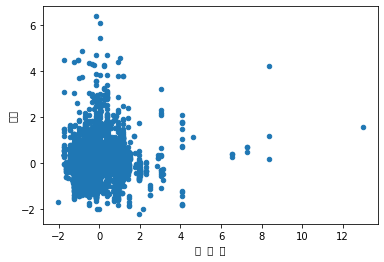

In [39]:
df7.plot.scatter(x='容  积  率',y='单价')